<a href="https://colab.research.google.com/github/jasmineyyip/sql-latency-predictor/blob/main/SQLLatencyPredictorV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup and Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

###Setup Database

In [6]:
# create and connect to SQLite
conn = sqlite3.connect("latency_project_v2.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS Customers")
cursor.execute("DROP TABLE IF EXISTS Orders")

In [7]:
# create customers table
cursor.execute("""
CREATE TABLE Customers (
    CustomerID INTEGER PRIMARY KEY,
    Name TEXT,
    Age INTEGER,
    Country TEXT,
    RegistrationDate TEXT
)
""")

# create orders table
cursor.execute("""
CREATE TABLE Orders (
    OrderID INTEGER PRIMARY KEY,
    CustomerID INTEGER,
    Amount REAL,
    OrderDate TEXT,
    ProductCategory TEXT,
    FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
)
""")

conn.commit()

###Generate Synthetic Data

In [8]:
import random
from datetime import datetime, timedelta

In [9]:
# generate customer data
names = ['Alice Johnson', 'Bob Smith', 'Charlie Brown', 'Diana Wilson', 'Eva Davis',
         'Frank Miller', 'Grace Lee', 'Henry Taylor', 'Ivy Chen', 'Jack Wilson']
countries = ['USA', 'Canada', 'Germany', 'France', 'Japan', 'Australia']

In [12]:
# generate customers
customers = []
for i in range(1, 15001): # 15000 customers
    name = random.choice(names)
    age = random.randint(18, 75)
    country = random.choice(countries)
    # random registration date in last 3 years
    reg_date = datetime.now() - timedelta(days=random.randint(1, 1095))
    customers.append((i, name, age, country, reg_date.strftime('%Y-%m-%d')))

In [11]:
# generate orders
categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty']
orders = []
for i in range(1, 50001):  # 50,000 orders
    customer_id = random.randint(1, 15000)
    amount = round(random.uniform(5, 2000), 2)
    # order date in last 2 years
    order_date = datetime.now() - timedelta(days=random.randint(1, 730))
    category = random.choice(categories)
    orders.append((i, customer_id, amount, order_date.strftime('%Y-%m-%d'), category))

In [13]:
# insert data
cursor.executemany("INSERT INTO Customers VALUES (?, ?, ?, ?, ?)", customers)
cursor.executemany("INSERT INTO Orders VALUES (?, ?, ?, ?, ?)", orders)
conn.commit()

In [17]:
# check data distribution
cursor.execute("SELECT COUNT(*) FROM Customers")
customer_count = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Orders")
order_count = cursor.fetchone()[0]
print(f"It has {customer_count:,} customers and {order_count:,} orders")

It has 15,000 customers and 50,000 orders


###Feature Extraction

In [18]:
def estimate_rows(query):
    try:
        # convert to COUNT query
        count_query = re.sub(r"(?i)select\s+.+?\s+from", "SELECT COUNT(*) FROM", query, count=1)
        # remove ORDER BY, LIMIT for count query
        count_query = re.sub(r'\bORDER BY\b.*', '', count_query, flags=re.IGNORECASE)
        count_query = re.sub(r'\bLIMIT\b.*', '', count_query, flags=re.IGNORECASE)

        cursor.execute(count_query)
        result = cursor.fetchone()
        return result[0] if result else 0

    except Exception:
        # estimate based on main table size
        try:
            tables = re.findall(r'\bFROM\s+(\w+)', query, flags=re.IGNORECASE)
            if tables:
                cursor.execute(f"SELECT COUNT(*) FROM {tables[0]}")
                base_size = cursor.fetchone()[0]

                # apply selectivity estimates
                selectivity = 1.0
                if 'WHERE' in query.upper():
                    selectivity *= 0.3
                if 'JOIN' in query.upper():
                    selectivity *= 0.15

                return int(base_size * selectivity)
        except:
            pass
        return 5000  # default fallback

In [19]:
def extract_features(query):
    # set basic structural features
    num_joins = len(re.findall(r'\bJOIN\b', query, flags=re.IGNORECASE))
    num_filters = len(re.findall(r'\b(WHERE|AND|OR)\b', query, flags=re.IGNORECASE))
    uses_group_by = int(bool(re.search(r'\bGROUP BY\b', query, flags=re.IGNORECASE)))
    uses_aggregation = int(bool(re.search(r'\b(SUM|AVG|COUNT|MIN|MAX)\b', query, flags=re.IGNORECASE)))

    # additional structural features
    num_tables = len(re.findall(r'\bFROM\s+(\w+)', query, flags=re.IGNORECASE))
    has_subquery = int(bool(re.search(r'\(.*SELECT.*\)', query, flags=re.IGNORECASE)))
    has_order_by = int(bool(re.search(r'\bORDER BY\b', query, flags=re.IGNORECASE)))
    has_limit = int(bool(re.search(r'\bLIMIT\b', query, flags=re.IGNORECASE)))
    has_having = int(bool(re.search(r'\bHAVING\b', query, flags=re.IGNORECASE)))

    # selectivity features
    num_equals = len(re.findall(r'=\s*[\'"]?\w+[\'"]?', query))
    num_ranges = len(re.findall(r'(BETWEEN|>|<|>=|<=)', query, flags=re.IGNORECASE))
    num_in_clauses = len(re.findall(r'\bIN\s*\(', query, flags=re.IGNORECASE))

    # expensive operations
    has_like = int(bool(re.search(r'\bLIKE\b', query, flags=re.IGNORECASE)))
    has_distinct = int(bool(re.search(r'\bDISTINCT\b', query, flags=re.IGNORECASE)))

    # query complexity metrics
    query_length = len(query.split())
    num_conditions = num_equals + num_ranges + num_in_clauses

    # complexity score
    complexity_score = (
        num_joins * 3 +
        num_filters * 1 +
        has_subquery * 4 +
        num_ranges * 2 +
        has_like * 3 +
        uses_group_by * 2 +
        uses_aggregation * 1 +
        has_order_by * 1
    )

    # Row estimation
    estimated_rows = estimate_rows(query)

    # Join complexity
    join_complexity = estimated_rows * (num_joins + 1) if num_joins > 0 else estimated_rows

    return {
        "num_joins": num_joins,
        "num_filters": num_filters,
        "uses_group_by": uses_group_by,
        "uses_aggregation": uses_aggregation,
        "num_tables": num_tables,
        "has_subquery": has_subquery,
        "has_order_by": has_order_by,
        "has_limit": has_limit,
        "has_having": has_having,
        "num_equals": num_equals,
        "num_ranges": num_ranges,
        "num_in_clauses": num_in_clauses,
        "has_like": has_like,
        "has_distinct": has_distinct,
        "query_length": query_length,
        "num_conditions": num_conditions,
        "complexity_score": complexity_score,
        "estimated_rows": estimated_rows,
        "join_complexity": join_complexity
    }

In [20]:
# run query multiple times and return median latency
def run_and_time_query_stable(query, runs=3):
    latencies = []

    for _ in range(runs):
        start = time.time()
        try:
            cursor.execute(query)
            _ = cursor.fetchall()
            end = time.time()
            latencies.append((end - start) * 1000)
        except Exception as e:
            print(f"Query failed: {e}")
            return None

    return np.median(latencies) if latencies else None

###Diverse Query Generation

In [22]:
# generate diverse and realistic SQL queries
def generate_diverse_queries(num_queries=1000):
    # basic query templates
    basic_templates = [
        "SELECT * FROM Customers WHERE Age > {age}",
        "SELECT * FROM Orders WHERE Amount < {amount}",
        "SELECT * FROM Customers WHERE Country = '{country}'",
        "SELECT * FROM Orders WHERE OrderDate > '2023-{month:02d}-01'",
    ]

    # intermediate templates
    intermediate_templates = [
        "SELECT AVG(Amount) FROM Orders WHERE ProductCategory = '{category}'",
        "SELECT Country, COUNT(*) FROM Customers GROUP BY Country",
        "SELECT * FROM Orders WHERE Amount BETWEEN {amount1} AND {amount2}",
        "SELECT DISTINCT ProductCategory FROM Orders WHERE Amount > {amount}",
        "SELECT * FROM Customers WHERE Name LIKE '{letter}%'",
    ]

    # advanced templates
    advanced_templates = [
        # subqueries
        "SELECT * FROM Customers WHERE CustomerID IN (SELECT CustomerID FROM Orders WHERE Amount > {amount})",
        "SELECT Name FROM Customers WHERE Age > (SELECT AVG(Age) FROM Customers WHERE Country = '{country}')",

        # complex joins
        "SELECT c.Name, COUNT(o.OrderID) as order_count FROM Customers c LEFT JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = '{country}' GROUP BY c.CustomerID HAVING COUNT(o.OrderID) > {min_orders}",
        "SELECT c.Name, o.Amount, o.ProductCategory FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Age BETWEEN {age1} AND {age2} AND o.Amount > {amount}",

        # multiple aggregations
        "SELECT Country, AVG(Age) as avg_age, COUNT(*) as total FROM Customers WHERE Age > {age} GROUP BY Country HAVING COUNT(*) > {min_count}",
        "SELECT ProductCategory, AVG(Amount), COUNT(*) FROM Orders WHERE OrderDate > '2023-{month:02d}-01' GROUP BY ProductCategory",

        # complex filtering with ORDER BY
        "SELECT * FROM Orders WHERE Amount > {amount} AND ProductCategory = '{category}' ORDER BY Amount DESC LIMIT {limit}",
        "SELECT c.*, o.Amount FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = '{country}' ORDER BY o.Amount DESC LIMIT {limit}",
    ]

    all_templates = basic_templates + intermediate_templates + advanced_templates
    queries = []

    categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty']
    countries = ['USA', 'Canada', 'Germany', 'France', 'Japan', 'Australia']
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

    for _ in range(num_queries):
        template = random.choice(all_templates)

        try:
            query = template.format(
                age=random.randint(18, 65),
                age1=random.randint(18, 40),
                age2=random.randint(41, 75),
                amount=random.randint(50, 1500),
                amount1=random.randint(10, 500),
                amount2=random.randint(500, 1500),
                country=random.choice(countries),
                category=random.choice(categories),
                month=random.randint(1, 12),
                min_orders=random.randint(1, 5),
                min_count=random.randint(10, 100),
                letter=random.choice(letters),
                limit=random.randint(5, 50)
            )
            queries.append(query)
        except KeyError:
            # skip templates that don't match the provided format parameters
            continue

    return queries

# generate diverse queries
queries = generate_diverse_queries(num_queries=1000)
print(f"Generated {len(queries)} diverse queries")

# print some examples
print("\nSample queries:")
for i, query in enumerate(queries[:5]):
    print(f"{i+1}. {query}")

Generated 1000 diverse queries

Sample queries:
1. SELECT c.Name, COUNT(o.OrderID) as order_count FROM Customers c LEFT JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = 'Canada' GROUP BY c.CustomerID HAVING COUNT(o.OrderID) > 5
2. SELECT c.*, o.Amount FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = 'Japan' ORDER BY o.Amount DESC LIMIT 24
3. SELECT * FROM Customers WHERE Country = 'France'
4. SELECT * FROM Orders WHERE Amount BETWEEN 94 AND 1268
5. SELECT c.Name, COUNT(o.OrderID) as order_count FROM Customers c LEFT JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = 'Canada' GROUP BY c.CustomerID HAVING COUNT(o.OrderID) > 1


###Data Collection and Feature Extraction

In [24]:
# collect data with enhanced features
data = []
failed_queries = 0

for i, query in enumerate(queries):
    # measure latency
    latency = run_and_time_query_stable(query, runs=2)

    if latency is not None:
        # extract features
        features = extract_features(query)
        features["latency_ms"] = latency
        features["query"] = query
        data.append(features)
    else:
        failed_queries += 1

# create dataframe
df = pd.DataFrame(data)
df = df.drop(columns=["query"])

print(f"\nDataset created:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Features: {len(df.columns)-1}")
print(f"   - Failed queries: {failed_queries}")
print(f"   - Success rate: {len(df)/(len(df)+failed_queries)*100:.1f}%")

# basic statistics
print(f"\nLatency statistics:")
print(f"   - Mean: {df['latency_ms'].mean():.2f}ms")
print(f"   - Median: {df['latency_ms'].median():.2f}ms")
print(f"   - Min: {df['latency_ms'].min():.2f}ms")
print(f"   - Max: {df['latency_ms'].max():.2f}ms")
print(f"   - Std: {df['latency_ms'].std():.2f}ms")

df.head()


Dataset created:
   - Total samples: 1,000
   - Features: 19
   - Failed queries: 0
   - Success rate: 100.0%

Latency statistics:
   - Mean: 23.95ms
   - Median: 14.45ms
   - Min: 1.88ms
   - Max: 169.62ms
   - Std: 23.61ms


,num_joins,num_filters,uses_group_by,uses_aggregation,num_tables,has_subquery,has_order_by,has_limit,has_having,num_equals,num_ranges,num_in_clauses,has_like,has_distinct,query_length,num_conditions,complexity_score,estimated_rows,join_complexity,latency_ms
0,1,1,1,1,1,0,0,0,1,2,1,0,0,0,27,3,9,7,14,59.084535
1,1,1,0,0,1,0,1,1,0,2,0,0,0,0,23,2,5,8694,17388,21.275878
2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,8,1,1,2412,2412,4.508734
3,0,2,0,0,1,0,0,0,0,0,1,0,0,0,10,1,4,29521,29521,45.050502
4,1,1,1,1,1,0,0,0,1,2,1,0,0,0,27,3,9,5,10,52.267313


###Data Analysis

Text(0, 0.5, 'Frequency')

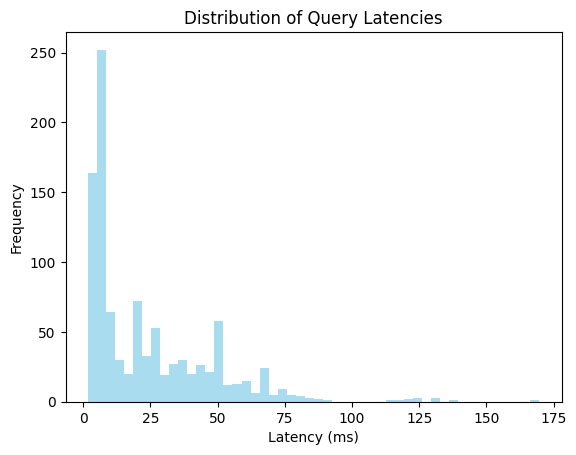

In [29]:
# visualize the latency distribution
plt.hist(df['latency_ms'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Query Latencies')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

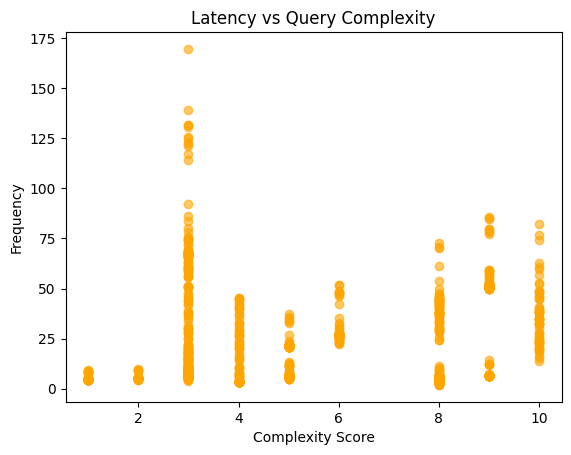

In [30]:
# latency v.s. complexity score
plt.scatter(df['complexity_score'], df['latency_ms'], alpha=0.6, color='orange')
plt.title('Latency vs Query Complexity')
plt.xlabel('Complexity Score')
plt.ylabel('Frequency')

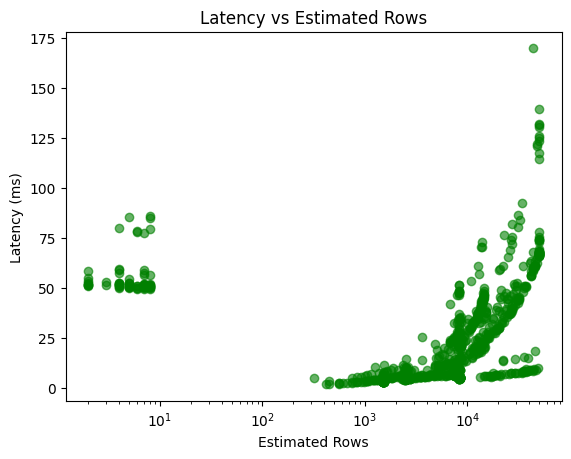

In [31]:
# latency v.s. estimated rows
plt.scatter(df['estimated_rows'], df['latency_ms'], alpha=0.6, color='green')
plt.title('Latency vs Estimated Rows')
plt.xlabel('Estimated Rows')
plt.ylabel('Latency (ms)')
plt.xscale('log')

###Model Training

In [40]:
X = df.drop(columns=["latency_ms"])
y = df["latency_ms"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}
predictions = {}

In [43]:
# train with random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

results['Random Forest'] = {'R²': r2, 'MAE': mae, 'RMSE': rmse, 'model': rf}
predictions['Random Forest'] = y_pred_rf

print(f"[Random Forest] R²: {r2:.3f}, MAE: {mae:.3f}ms, RMSE: {rmse:.3f}ms")

[Random Forest] R²: 0.775, MAE: 4.843ms, RMSE: 12.185ms


In [42]:
# train with XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

results['XGBoost'] = {'R²': r2, 'MAE': mae, 'RMSE': rmse, 'model': xgb}
predictions['XGBoost'] = y_pred_xgb

print(f"[XGBoost] R²: {r2:.3f}, MAE: {mae:.3f}ms, RMSE: {rmse:.3f}ms")

[XGBoost] R²: 0.798, MAE: 4.452ms, RMSE: 11.548ms


In [44]:
# train with gradient boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

r2 = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

results['Gradient Boosting'] = {'R²': r2, 'MAE': mae, 'RMSE': rmse, 'model': gb}
predictions['Gradient Boosting'] = y_pred_gb

print(f"[Gradient Boosting] R²: {r2:.3f}, MAE: {mae:.3f}ms, RMSE: {rmse:.3f}ms")

[Gradient Boosting] R²: 0.778, MAE: 4.967ms, RMSE: 12.092ms


In [71]:
summary_df = pd.DataFrame({
    "R² Score": {name: results[name]['R²'] for name in results},
    "MAE (ms)": {name: results[name]['MAE'] for name in results},
    "RMSE (ms)": {name: results[name]['RMSE'] for name in results}
})

print("Model Evaluation Summary")
display(summary_df.round(3))

Model Evaluation Summary


,R² Score,MAE (ms),RMSE (ms)
Random Forest,0.775,4.843,12.185
XGBoost,0.798,4.452,11.548
Gradient Boosting,0.778,4.967,12.092


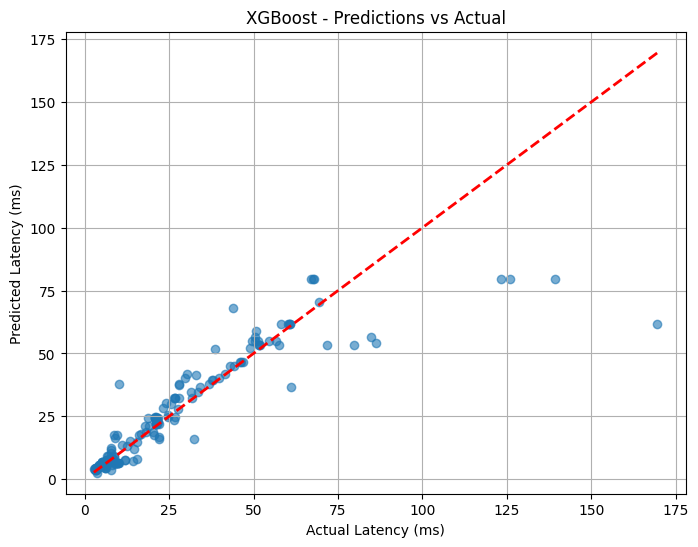

In [47]:
# compare predictions to actual results
best_model = max(results, key=lambda x: results[x]['R²'])
best_preds = predictions[best_model]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'{best_model} - Predictions vs Actual')
plt.xlabel('Actual Latency (ms)')
plt.ylabel('Predicted Latency (ms)')
plt.grid(True)
plt.show()

In [49]:
print(f"Best performing model: {best_model} (R² = {results[best_model]['R²']:.3f})")

Best performing model: XGBoost (R² = 0.798)


###Feature Important Analysis

In [52]:
best_model_obj = results[best_model]['model']

# use the Random Forest component for feature importance
if best_model == 'Ensemble':
    feature_model = best_model_obj.named_estimators_['rf']
else:
    feature_model = best_model_obj

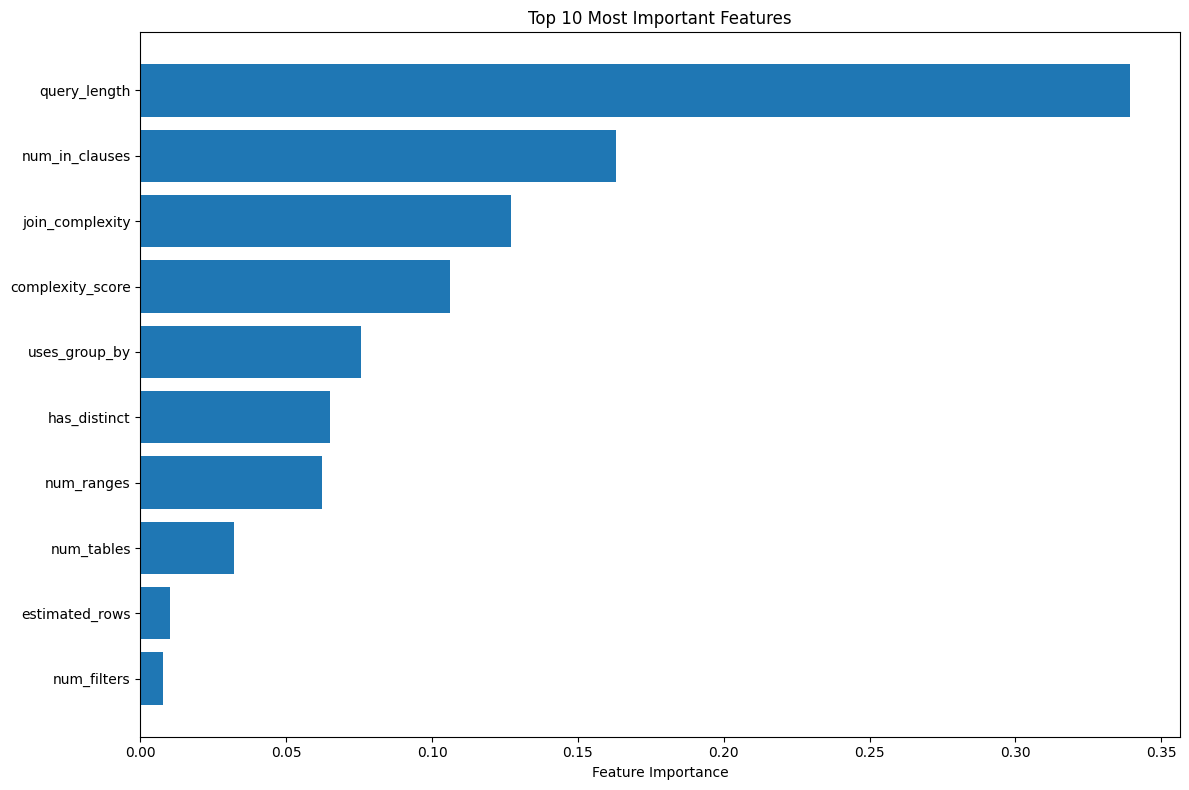

 Top 10 Most Important Features:
    1. query_length: 0.3395
    2. num_in_clauses: 0.1630
    3. join_complexity: 0.1269
    4. complexity_score: 0.1061
    5. uses_group_by: 0.0756
    6. has_distinct: 0.0649
    7. num_ranges: 0.0623
    8. num_tables: 0.0322
    9. estimated_rows: 0.0102
   10. num_filters: 0.0077


In [66]:
# get feature importance
if hasattr(feature_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': feature_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # plot feature importance
    plt.figure(figsize=(12, 8))
    top_10_features = feature_importance.head(10)
    plt.barh(range(len(top_10_features)), top_10_features['importance'])
    plt.yticks(range(len(top_10_features)), top_10_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print(" Top 10 Most Important Features:")
    for i, (idx, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']}: {row['importance']:.4f}")

###Adaptive Predictor

In [57]:
# adaptive predictor which handles workload drift
class AdaptiveLatencyPredictor:
    def __init__(self, window_size=200, retrain_threshold=0.3):
        self.model = None
        self.window = deque(maxlen=window_size)
        self.prediction_errors = deque(maxlen=100)
        self.retrain_threshold = retrain_threshold
        self.is_trained = False
        self.retrain_count = 0

    def update(self, features, actual_latency):
        self.window.append((features, actual_latency))

        # train if we have enough samples
        if len(self.window) >= 50 and not self.is_trained:
            self._retrain()

        # check if we need to retrain due to drift
        elif len(self.prediction_errors) >= 20:
            recent_error = np.mean(list(self.prediction_errors)[-20:])
            if recent_error > self.retrain_threshold:
                self._retrain()

    def _retrain(self):
        if len(self.window) < 20:
            return

        X = pd.DataFrame([item[0] for item in self.window])
        y = [item[1] for item in self.window]

        # use best performing model
        self.model = XGBRegressor(n_estimators=50, max_depth=6, random_state=42)
        self.model.fit(X, y)
        self.is_trained = True
        self.retrain_count += 1

        # clear error history
        self.prediction_errors.clear()

    def predict_and_monitor(self, query):
        features = extract_features(query)

        if not self.is_trained:
            predicted = 15.0
        else:
            X_pred = pd.DataFrame([features])
            predicted = self.model.predict(X_pred)[0]

        # execute query and measure actual latency
        actual = run_and_time_query_stable(query, runs=1)

        if actual is not None:
            # calculate relative error
            error = abs(predicted - actual) / max(actual, 1.0)
            self.prediction_errors.append(error)

            # update model with new observation
            self.update(features, actual)

        return predicted, actual, error if actual else None

# initialize adaptive predictor
adaptive_predictor = AdaptiveLatencyPredictor()

###Test Adaptive Predictor

In [59]:
# generate test queries for adaptive predictor
test_queries = generate_diverse_queries(num_queries=50)

predictions_log = []

# test with first 20 queries
for i, query in enumerate(test_queries[:20]):
    pred, actual, error = adaptive_predictor.predict_and_monitor(query)

    if actual is not None:
        predictions_log.append({
            'query_num': i+1,
            'predicted': pred,
            'actual': actual,
            'error': error,
            'abs_error': abs(pred - actual)
        })

        print(f"Query {i+1:2d}: Predicted={pred:6.2f}ms, Actual={actual:6.2f}ms, "
              f"Error={error*100:5.1f}%, Abs_Error={abs(pred-actual):5.2f}ms")

Query  1: Predicted= 15.00ms, Actual=  6.82ms, Error=120.0%, Abs_Error= 8.18ms
Query  2: Predicted= 15.00ms, Actual=  7.07ms, Error=112.0%, Abs_Error= 7.93ms
Query  3: Predicted= 15.00ms, Actual= 43.04ms, Error= 65.1%, Abs_Error=28.04ms
Query  4: Predicted= 15.00ms, Actual= 17.49ms, Error= 14.3%, Abs_Error= 2.49ms
Query  5: Predicted= 15.00ms, Actual=  3.19ms, Error=370.4%, Abs_Error=11.81ms
Query  6: Predicted= 15.00ms, Actual=  5.67ms, Error=164.3%, Abs_Error= 9.33ms
Query  7: Predicted= 15.00ms, Actual= 51.09ms, Error= 70.6%, Abs_Error=36.09ms
Query  8: Predicted= 15.00ms, Actual= 37.32ms, Error= 59.8%, Abs_Error=22.32ms
Query  9: Predicted= 15.00ms, Actual= 44.52ms, Error= 66.3%, Abs_Error=29.52ms
Query 10: Predicted= 15.00ms, Actual= 88.84ms, Error= 83.1%, Abs_Error=73.84ms
Query 11: Predicted= 15.00ms, Actual=152.61ms, Error= 90.2%, Abs_Error=137.61ms
Query 12: Predicted= 15.00ms, Actual=275.87ms, Error= 94.6%, Abs_Error=260.87ms
Query 13: Predicted= 15.00ms, Actual=165.93ms, Err


 Adaptive Predictor Performance:
   Average Error: 93.8%
   Average Absolute Error: 62.91ms
   Retraining Count: 1
   Window Size: 20


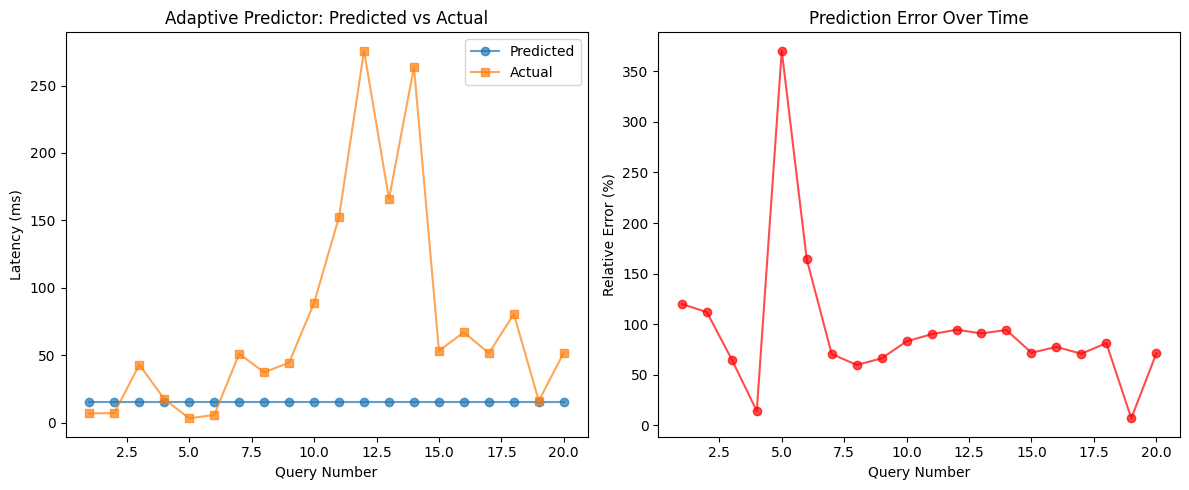

In [60]:
# analyze adaptive predictor performance
if predictions_log:
    log_df = pd.DataFrame(predictions_log)

    print("\n Adaptive Predictor Performance:")
    print(f"   Average Error: {log_df['error'].mean()*100:.1f}%")
    print(f"   Average Absolute Error: {log_df['abs_error'].mean():.2f}ms")
    print(f"   Retraining Count: {adaptive_predictor.retrain_count}")
    print(f"   Window Size: {len(adaptive_predictor.window)}")

    # plot adaptive predictor performance
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(log_df['query_num'], log_df['predicted'], 'o-', label='Predicted', alpha=0.7)
    plt.plot(log_df['query_num'], log_df['actual'], 's-', label='Actual', alpha=0.7)
    plt.xlabel('Query Number')
    plt.ylabel('Latency (ms)')
    plt.title('Adaptive Predictor: Predicted vs Actual')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(log_df['query_num'], log_df['error']*100, 'o-', color='red', alpha=0.7)
    plt.xlabel('Query Number')
    plt.ylabel('Relative Error (%)')
    plt.title('Prediction Error Over Time')

    plt.tight_layout()
    plt.show()

###Production Inference Example

In [61]:
# production inference example
def production_inference_example():
    # use the best model from training
    best_model_obj = results[best_model]['model']

    # example new queries for prediction
    new_queries = [
        "SELECT COUNT(*) FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID WHERE Age > 35 AND Country = 'USA'",
        "SELECT AVG(Amount) FROM Orders WHERE ProductCategory = 'Electronics' AND OrderDate > '2023-06-01'",
        "SELECT c.Name, SUM(o.Amount) FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = 'Germany' GROUP BY c.CustomerID HAVING SUM(o.Amount) > 1000",
        "SELECT DISTINCT ProductCategory FROM Orders WHERE Amount BETWEEN 100 AND 500",
        "SELECT * FROM Orders WHERE CustomerID IN (SELECT CustomerID FROM Customers WHERE Age < 30) ORDER BY Amount DESC LIMIT 10"
    ]

    for i, query in enumerate(new_queries):
        # extract features
        features = extract_features(query)
        X_new = pd.DataFrame([features])

        # predict with best model
        predicted_latency = best_model_obj.predict(X_new)[0]

        # actually run the query to compare
        actual_latency = run_and_time_query_stable(query, runs=1)

        print(f"\nQuery {i+1}:")
        print(f"SQL: {query}")
        print(f"Predicted: {predicted_latency:.2f}ms")
        if actual_latency:
            error_pct = abs(predicted_latency - actual_latency) / actual_latency * 100
            print(f"Actual: {actual_latency:.2f}ms")
            print(f"Error: {error_pct:.1f}%")
        else:
            print("Actual: Failed to execute")

        # show key features that influenced the prediction
        print(f"Key features - Complexity: {features['complexity_score']}, "
              f"Est. Rows: {features['estimated_rows']}, "
              f"Joins: {features['num_joins']}")

production_inference_example()


Query 1:
SQL: SELECT COUNT(*) FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID WHERE Age > 35 AND Country = 'USA'
Predicted: 22.91ms
Actual: 22.85ms
Error: 0.3%
Key features - Complexity: 8, Est. Rows: 5680, Joins: 1

Query 2:
SQL: SELECT AVG(Amount) FROM Orders WHERE ProductCategory = 'Electronics' AND OrderDate > '2023-06-01'
Predicted: 17.01ms
Actual: 7.67ms
Error: 121.8%
Key features - Complexity: 5, Est. Rows: 8473, Joins: 0

Query 3:
SQL: SELECT c.Name, SUM(o.Amount) FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Country = 'Germany' GROUP BY c.CustomerID HAVING SUM(o.Amount) > 1000
Predicted: 13.87ms
Actual: 28.50ms
Error: 51.3%
Key features - Complexity: 9, Est. Rows: 2, Joins: 1

Query 4:
SQL: SELECT DISTINCT ProductCategory FROM Orders WHERE Amount BETWEEN 100 AND 500
Predicted: 6.26ms
Actual: 7.56ms
Error: 17.2%
Key features - Complexity: 4, Est. Rows: 10096, Joins: 0

Query 5:
SQL: SELECT * FROM Orders WHERE CustomerID IN (SELECT

###Workload Drift Simulation


 Testing Phase A (Simple):
   Average Error: 46.4%
   Average Predicted: 31.78ms
   Average Actual: 59.11ms

 Testing Phase B (Medium):
   Average Error: 130.8%
   Average Predicted: 28.92ms
   Average Actual: 22.53ms

 Testing Phase C (Complex):
   Average Error: 25.3%
   Average Predicted: 27.24ms
   Average Actual: 35.83ms


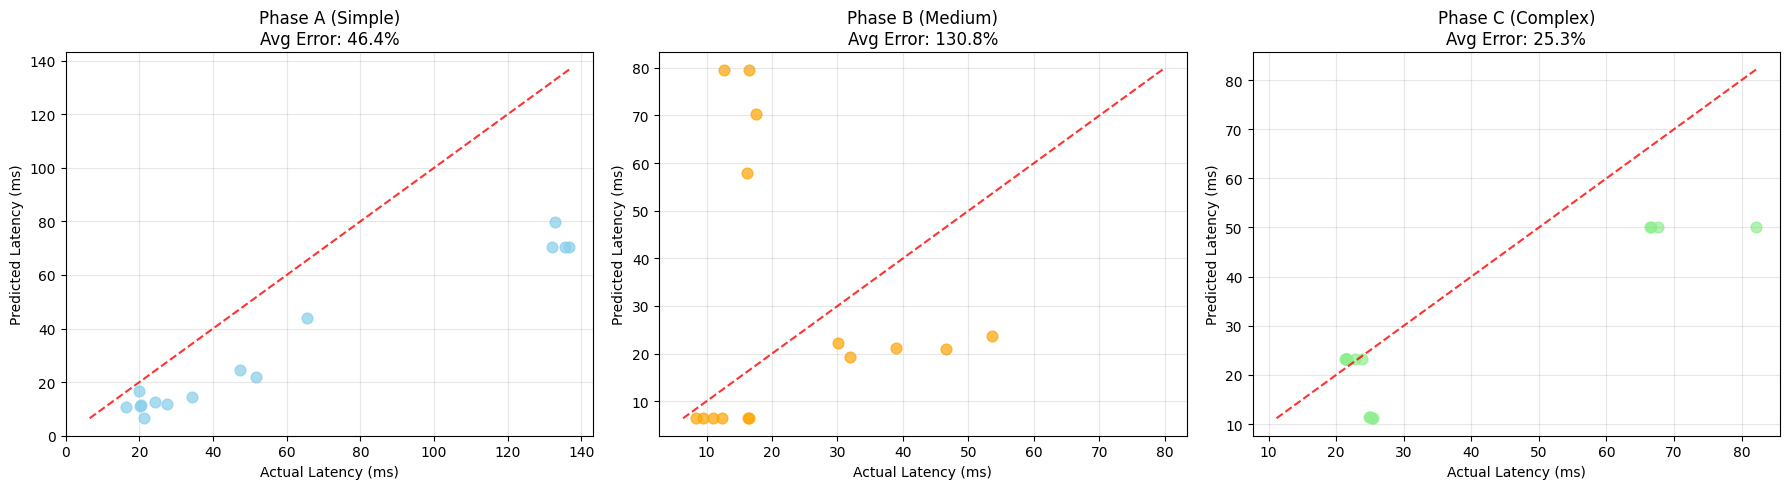


 Workload Drift Summary:
   Phase A (Simple): 46.4% average error
   Phase B (Medium): 130.8% average error
   Phase C (Complex): 25.3% average error


In [62]:
# simulate workload drift between different phases
def simulate_workload_drift():
    """Simulate how model performs under workload drift"""

    # simple queries
    phase_A_templates = [
        "SELECT * FROM Customers WHERE Age > {age}",
        "SELECT * FROM Orders WHERE Amount < {amount}",
        "SELECT * FROM Orders WHERE OrderDate > '2023-{month:02d}-01'"
    ]

    # complex queries
    phase_B_templates = [
        "SELECT c.Name, o.Amount FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.Age > {age} AND c.Country = '{country}'",
        "SELECT Country, COUNT(*) FROM Customers GROUP BY Country",
        "SELECT AVG(Amount) FROM Orders WHERE OrderDate > '2023-{month:02d}-01'",
        "SELECT o.OrderID, o.Amount FROM Orders o JOIN Customers c ON o.CustomerID = c.CustomerID WHERE c.Country = '{country}' AND c.Age BETWEEN {age1} AND {age2}"
    ]

    # very complex queries
    phase_C_templates = [
        "SELECT c.Country, AVG(o.Amount), COUNT(o.OrderID) FROM Customers c JOIN Orders o ON c.CustomerID = o.CustomerID WHERE o.ProductCategory IN ('Electronics', 'Books') GROUP BY c.Country HAVING COUNT(o.OrderID) > {min_orders}",
        "SELECT * FROM Orders WHERE CustomerID IN (SELECT CustomerID FROM Customers WHERE Country = '{country}' AND Age > (SELECT AVG(Age) FROM Customers))",
        "SELECT c.Name, SUM(o.Amount) as total_spent FROM Customers c LEFT JOIN Orders o ON c.CustomerID = o.CustomerID WHERE c.RegistrationDate > '2023-01-01' GROUP BY c.CustomerID ORDER BY total_spent DESC LIMIT {limit}"
    ]

    def generate_phase_queries(templates, count=30):
        queries = []
        countries = ['USA', 'Canada', 'Germany', 'France', 'Japan']

        for _ in range(count):
            template = random.choice(templates)
            try:
                query = template.format(
                    age=random.randint(25, 60),
                    age1=random.randint(20, 40),
                    age2=random.randint(41, 70),
                    amount=random.randint(100, 1000),
                    country=random.choice(countries),
                    month=random.randint(1, 12),
                    min_orders=random.randint(5, 20),
                    limit=random.randint(10, 50)
                )
                queries.append(query)
            except KeyError:
                continue
        return queries

    # generate queries for each phase
    queries_A = generate_phase_queries(phase_A_templates, 30)
    queries_B = generate_phase_queries(phase_B_templates, 30)
    queries_C = generate_phase_queries(phase_C_templates, 30)

    # test model performance on each phase
    best_model_obj = results[best_model]['model']
    phase_results = {}

    for phase_name, phase_queries in [('Phase A (Simple)', queries_A),
                                      ('Phase B (Medium)', queries_B),
                                      ('Phase C (Complex)', queries_C)]:

        predictions = []
        actuals = []
        errors = []

        print(f"\n Testing {phase_name}:")

        for i, query in enumerate(phase_queries[:15]):
            features = extract_features(query)
            X_new = pd.DataFrame([features])

            predicted = best_model_obj.predict(X_new)[0]
            actual = run_and_time_query_stable(query, runs=1)

            if actual is not None:
                error = abs(predicted - actual) / actual
                predictions.append(predicted)
                actuals.append(actual)
                errors.append(error)

        if errors:
            phase_results[phase_name] = {
                'mean_error': np.mean(errors) * 100,
                'mean_predicted': np.mean(predictions),
                'mean_actual': np.mean(actuals),
                'predictions': predictions,
                'actuals': actuals,
                'errors': errors
            }

            print(f"   Average Error: {np.mean(errors)*100:.1f}%")
            print(f"   Average Predicted: {np.mean(predictions):.2f}ms")
            print(f"   Average Actual: {np.mean(actuals):.2f}ms")

    # visualize drift results
    if phase_results:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        phase_names = list(phase_results.keys())
        colors = ['skyblue', 'orange', 'lightgreen']

        for i, (phase_name, color) in enumerate(zip(phase_names, colors)):
            data = phase_results[phase_name]

            axes[i].scatter(data['actuals'], data['predictions'],
                          alpha=0.7, color=color, s=60)

            # perfect prediction line
            min_val = min(min(data['actuals']), min(data['predictions']))
            max_val = max(max(data['actuals']), max(data['predictions']))
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

            axes[i].set_xlabel('Actual Latency (ms)')
            axes[i].set_ylabel('Predicted Latency (ms)')
            axes[i].set_title(f'{phase_name}\nAvg Error: {data["mean_error"]:.1f}%')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # summary comparison
        print(f"\n Workload Drift Summary:")
        for phase_name in phase_names:
            data = phase_results[phase_name]
            print(f"   {phase_name}: {data['mean_error']:.1f}% average error")

    return phase_results

drift_results = simulate_workload_drift()

###Model Insights

In [67]:
# Generate insights and recommendations
def generate_insights():
    # best model performance
    best_r2 = results[best_model]['R²']
    best_mae = results[best_model]['MAE']

    print(f"Best Model: {best_model}")
    print(f"   • R² Score: {best_r2:.3f} ({best_r2*100:.1f}% variance explained)")
    print(f"   • Mean Absolute Error: {best_mae:.2f}ms")

    if best_r2 > 0.8:
        print(f"   • Performance: Excellent (R² > 0.8)")
    elif best_r2 > 0.7:
        print(f"   • Performance: Good (R² > 0.7)")
    elif best_r2 > 0.6:
        print(f"   • Performance: Fair (R² > 0.6)")
    else:
        print(f"   • Performance: Needs Improvement (R² < 0.6)")

    # feature insights
    if 'feature_importance' in locals():
        top_3_features = feature_importance.head(3)
        print(f"\n TOP PREDICTIVE FEATURES:")
        for i, (_, row) in enumerate(top_3_features.iterrows()):
            print(f"   {i+1}. {row['feature']}: {row['importance']:.3f}")

    # workload drift insights
    if 'drift_results' in locals():
        print(f"\n  WORKLOAD DRIFT ANALYSIS:")
        for phase_name, data in drift_results.items():
            error = data['mean_error']
            if error < 20:
                status = "Good"
            elif error < 35:
                status = "Fair"
            else:
                status = "Poor"
            print(f"   • {phase_name}: {error:.1f}% error {status}")

generate_insights()

Best Model: XGBoost
   • R² Score: 0.798 (79.8% variance explained)
   • Mean Absolute Error: 4.45ms
   • Performance: Good (R² > 0.7)


###Summary

In [70]:
# final summary
print(f"   • Dataset: {len(df):,} queries with {len(df.columns)-1} features")
print(f"   • Best Model: {best_model} (R² = {results[best_model]['R²']:.3f})")
print(f"   • Improvement over baseline: +{(results[best_model]['R²'] - 0.663)*100:.1f}% R²")
print(f"   • Mean Absolute Error: {results[best_model]['MAE']:.2f}ms")

# cleanup
conn.close()

   • Dataset: 1,000 queries with 19 features
   • Best Model: XGBoost (R² = 0.798)
   • Improvement over baseline: +13.5% R²
   • Mean Absolute Error: 4.45ms
